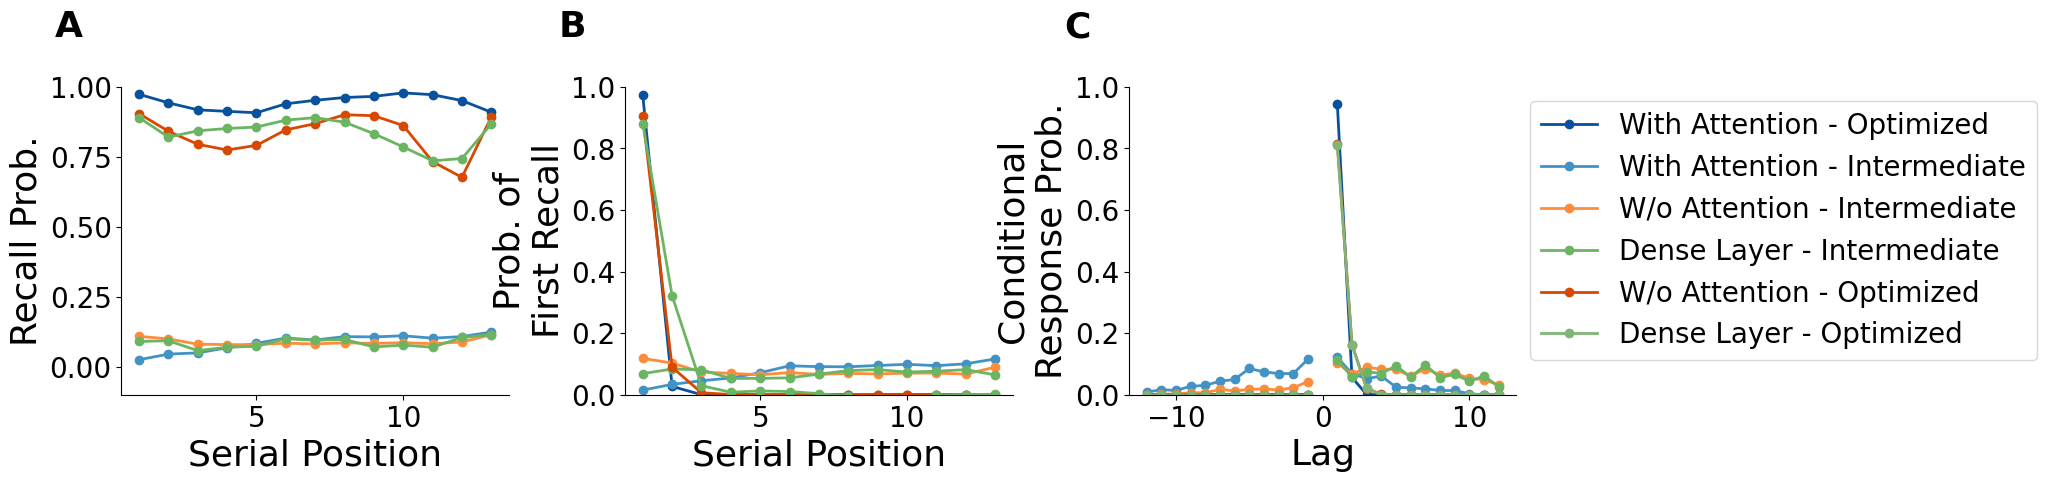

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import re
import random
from matplotlib.gridspec import GridSpec
import pickle
from pathlib import Path
import ipynbname

nb_path = Path(ipynbname.path())
data_path = nb_path.parent.parent

from nmt_cmr_parallels.utils.evaluation_utils import (calculate_conditional_recall_probability, 
                                                  calculate_recall_probability,
                                                  calculate_first_recall_probability)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def extract_number(label):
    match = re.search(r'Epoch-(\d+)', label)
    return int(match.group(1)) if match else float('inf')

def extract_sort_keys(file_path):
    attention_type_match = re.search(r'/(Attention|NoAttention)-', file_path)
    dimension_match = re.search(r'-(\d+)Dim', file_path)

    attention_type = attention_type_match.group(1) if attention_type_match else ''
    dimension_number = int(dimension_match.group(1)) if dimension_match else 0

    return attention_type, dimension_number

def extract_dimension(filename):
    match = re.search(r'(\d+)Dim\.json$', filename)
    return int(match.group(1)) if match else 0

no_attention_dir = data_path / "resource" / "evaluations" / "no_attention"
attention_dir = data_path / "resource" / "evaluations" / "attention"
hidden_dim_dir = data_path / "resource" / "evaluations" / "varying_hidden_dim"
denseeval_filepath = "denselayer_evaluation.pkl"

no_attention_files = [os.path.join(no_attention_dir, x) for x in os.listdir(str(no_attention_dir)) if x.endswith('.json')]
attention_files = [os.path.join(attention_dir, x) for x in os.listdir(str(attention_dir)) if x.endswith('.json') and 'Human' not in x]
hidden_dim_files = [os.path.join(hidden_dim_dir, x) for x in os.listdir(str(hidden_dim_dir)) if x.endswith('.json')]
with open(denseeval_filepath, "rb") as f:
    dense_eval = pickle.load(f)

bigfont = 26
smallfont = 20
omit_first_k = 1

fig = plt.figure(figsize=(18, 4))
gs = GridSpec(nrows=1, ncols=3, figure=fig, width_ratios=[1,1,1])

# ==== D: Recall Probability Curves (w/ and w/o Attention) ====
ax = fig.add_subplot(gs[0, 0])
ax.set_xlabel('Serial Position', fontsize=bigfont)
ax.set_ylabel('Recall Prob.', fontsize=bigfont)
ax.set_ylim((-0.1,1.0))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
files_of_interest = []
for file in attention_files:
    if 'Epoch-0.' in file or 'Epoch-9.' in file:
        files_of_interest.append(file)
for file in no_attention_files:
    if 'Epoch-110' in file or 'Epoch-20' in file:
        files_of_interest.append(file)
for filepath in files_of_interest:
    with open(filepath,'r') as f:
        data = json.load(f)
    if omit_first_k is not None:
        data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
        data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]
    recall_probabilities = calculate_recall_probability(data['original_sequences'], data['predicted_sequences'])
    if 'Epoch-9' in filepath:
        label = 'With Attention - Optimized'
        color = "#08519c"
    elif 'Epoch-0' in filepath:
        label = 'With Attention - Intermediate'
        color = "#4292c6"
    elif 'Epoch-110' in filepath:
        label = 'W/o Attention - Optimized'
        color = "#d94801"
        positions = list(range(1, len(recall_probabilities) + 1))
        ax.plot(positions, recall_probabilities, marker='o', color=color, label=label, linewidth=2, markersize=6)
        color = "#6bb562"
        recall_probabilities = dense_eval['spc_opt']

    else:
        label = 'W/o Attention - Intermediate'
        color = "#fd8d3c"
        positions = list(range(1, len(recall_probabilities) + 1))
        ax.plot(positions, recall_probabilities, marker='o', color=color, label=label, linewidth=2, markersize=6)
        color = "#6bb562"
        recall_probabilities = dense_eval['spc_intermed']
    positions = list(range(1, len(recall_probabilities) + 1))
    ax.plot(positions, recall_probabilities, marker='o', color=color, label=label, linewidth=2, markersize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
##ax.legend(fontsize=smallfont)
ax.text(-0.1, 1.25, 'A', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')

# ==== E: First Recall Probability Curves ====
ax = fig.add_subplot(gs[0, 1])
ax.set_xlabel('Serial Position', fontsize=bigfont)
ax.set_ylabel('Prob. of\nFirst Recall', fontsize=bigfont)
ax.set_ylim((0.0,1.0))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
for filepath in files_of_interest:
    with open(filepath,'r') as f:
        data = json.load(f)
    if omit_first_k is not None:
        data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
        data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]
    recall_probabilities = calculate_first_recall_probability(data['original_sequences'], data['predicted_sequences'])
    if 'Epoch-9' in filepath:
        label = 'With Attention - Optimized'
        color = "#08519c"
    elif 'Epoch-0' in filepath:
        label = 'With Attention - Intermediate'
        color = "#4292c6"
    elif 'Epoch-110' in filepath:
        label = 'W/o Attention - Optimized'
        color = "#d94801"
        ax.plot(positions, recall_probabilities, marker='o', color=color, label=label, linewidth=2, markersize=6)
        color = "#6bb562"
        recall_probabilities = dense_eval['pfr_opt']

    else:
        label = 'W/o Attention - Intermediate'
        color = "#fd8d3c"
        ax.plot(positions, recall_probabilities, marker='o', color=color, label=label, linewidth=2, markersize=6)
        color = "#6bb562"
        recall_probabilities = dense_eval['pfr_intermed']
        
    positions = list(range(1, len(recall_probabilities) + 1))
    ax.plot(positions, recall_probabilities, marker='o', color=color, label=label, linewidth=2, markersize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.legend(fontsize=smallfont)
ax.text(-0.1, 1.25, 'B', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')

# ==== F: CRP (Conditional Response Probability) Curves ====
ax = fig.add_subplot(gs[0, 2])
ax.set_xlabel('Lag', fontsize=bigfont)
ax.set_ylabel('Conditional\nResponse Prob.', fontsize=bigfont)
ax.tick_params(axis='both', which='major', labelsize=smallfont)
for filepath in files_of_interest:
    with open(filepath,'r') as f:
        data = json.load(f)
    if omit_first_k is not None:
        data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
        data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]
    probabilities, lags = calculate_conditional_recall_probability(data['original_sequences'], data['predicted_sequences'])
    positive_lags, pos_idxs = [lag for lag in lags if lag > 0], [i for i, lag in enumerate(lags) if lag > 0]
    positive_probs = [probabilities[idx] for idx in pos_idxs]
    negative_lags, neg_idxs = [lag for lag in lags if lag < 0], [i for i, lag in enumerate(lags) if lag < 0]
    negative_probs = [probabilities[idx] for idx in neg_idxs]
    if 'Epoch-9' in filepath:
        label = 'With Attention - Optimized'
        color = "#08519c"
    elif 'Epoch-0' in filepath:
        label = 'With Attention - Intermediate'
        color = "#4292c6"
    elif 'Epoch-110' in filepath:
        label = 'W/o Attention - Optimized'
        color = "#d94801"
        ax.plot(negative_lags, negative_probs, marker='o', color=color, label=label, linewidth=2, markersize=6)
        ax.plot(positive_lags, positive_probs, marker='o', color=color, linewidth=2, markersize=6)
        label = 'Dense Layer - Optimized'
        color = "#7fb577"

        negative_probs = dense_eval['crpneg_opt']
        positive_probs = dense_eval['crppos_opt']

    else:
        label = 'W/o Attention - Intermediate'
        color = "#fd8d3c"
        ax.plot(negative_lags, negative_probs, marker='o', color=color, label=label, linewidth=2, markersize=6)
        ax.plot(positive_lags, positive_probs, marker='o', color=color, linewidth=2, markersize=6)
        label = 'Dense Layer - Intermediate'
        color = "#6bb562"
        negative_probs = dense_eval['crpneg_intermed']
        positive_probs = dense_eval['crppos_intermed']

    ax.plot(negative_lags, negative_probs, marker='o', color=color, label=label, linewidth=2, markersize=6)
    ax.plot(positive_lags, positive_probs, marker='o', color=color, linewidth=2, markersize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(bbox_to_anchor=(1, 1), fontsize=smallfont)
ax.set_ylim(0.0,1.0)
ax.text(-0.1, 1.25, 'C', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()
